# Cerebellar volumetry and cortical thickness covariance 
## Data: 
    - 1. Freesurfer cortical thickness measures in Des/DKT atlas;
    - 2. Cerebellar lobular volumnes from SUIT/MDTB/MAGeT softwares; 
## Atlases
    -1. Des 2009a: L+R: 74 regions + WhiteSurfArea_area + MeanThickness_thickness
    -2. DKT:       L+R: 31 regions + WhiteSurfArea_area + MeanThickness_thickness
## Cohorts
- The augmented cohort 211: MNI ET/ matched NC (34/177).

## Tasks: exploring the structural covariance with cerebellar/lolbular volumes 
    - 1. ??
    - 2. ??
## recommendations from literature
    - use cortical volumne/surface areas
Ref: [Reliability and comparability of human brain structural covariance networks](https://www.sciencedirect.com/science/article/pii/S1053811920305905?via%3Dihub)

In [1]:
#reading/merging/selecting data
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/codes')

data_dir = Path("/codes/tab_data")
# data files
matched_des_all_file = data_dir/ 'matched_Des-all_qced.csv'
matched_DKT_all_file = data_dir/ 'matched_DKT-all_qced.csv'
data_df = pd.read_csv(matched_des_all_file , sep=',', header=0, index_col=0);

In [2]:
# preproc ROI list for analysis
# cerebellum ROIs
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 
                 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII',
                 'Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 
                 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MAGeT_l_labels = ['L_I_IV',  'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 
                 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X'];  # NO  'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'
MAGeT_r_labels = ['R_I_IV','R_V','R_VI','R_Crus_I','R_Crus_II',
                 'R_VIIB','R_VIIIA','R_VIIIB','R_IX','R_X'];  # NO  'Right_Dentate','Right_Interposed','Right_Fastigial'
length_lobule_list=len(MAGeT_l_labels)

cerebellum_list = ['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex'];

# Freesurfer 'Destrieux' 2009a atlas, and DKT atlas ROIs:
Des_atlas_str="lh_G&S_frontomargin_thickness	lh_G&S_occipital_inf_thickness	lh_G&S_paracentral_thickness	lh_G&S_subcentral_thickness	lh_G&S_transv_frontopol_thickness	lh_G&S_cingul-Ant_thickness	lh_G&S_cingul-Mid-Ant_thickness	lh_G&S_cingul-Mid-Post_thickness	lh_G_cingul-Post-dorsal_thickness	lh_G_cingul-Post-ventral_thickness	lh_G_cuneus_thickness	lh_G_front_inf-Opercular_thickness	lh_G_front_inf-Orbital_thickness	lh_G_front_inf-Triangul_thickness	lh_G_front_middle_thickness	lh_G_front_sup_thickness	lh_G_Ins_lg&S_cent_ins_thickness	lh_G_insular_short_thickness	lh_G_occipital_middle_thickness	lh_G_occipital_sup_thickness	lh_G_oc-temp_lat-fusifor_thickness	lh_G_oc-temp_med-Lingual_thickness	lh_G_oc-temp_med-Parahip_thickness	lh_G_orbital_thickness	lh_G_pariet_inf-Angular_thickness	lh_G_pariet_inf-Supramar_thickness	lh_G_parietal_sup_thickness	lh_G_postcentral_thickness	lh_G_precentral_thickness	lh_G_precuneus_thickness	lh_G_rectus_thickness	lh_G_subcallosal_thickness	lh_G_temp_sup-G_T_transv_thickness	lh_G_temp_sup-Lateral_thickness	lh_G_temp_sup-Plan_polar_thickness	lh_G_temp_sup-Plan_tempo_thickness	lh_G_temporal_inf_thickness	lh_G_temporal_middle_thickness	lh_Lat_Fis-ant-Horizont_thickness	lh_Lat_Fis-ant-Vertical_thickness	lh_Lat_Fis-post_thickness	lh_Pole_occipital_thickness	lh_Pole_temporal_thickness	lh_S_calcarine_thickness	lh_S_central_thickness	lh_S_cingul-Marginalis_thickness	lh_S_circular_insula_ant_thickness	lh_S_circular_insula_inf_thickness	lh_S_circular_insula_sup_thickness	lh_S_collat_transv_ant_thickness	lh_S_collat_transv_post_thickness	lh_S_front_inf_thickness	lh_S_front_middle_thickness	lh_S_front_sup_thickness	lh_S_interm_prim-Jensen_thickness	lh_S_intrapariet&P_trans_thickness	lh_S_oc_middle&Lunatus_thickness	lh_S_oc_sup&transversal_thickness	lh_S_occipital_ant_thickness	lh_S_oc-temp_lat_thickness	lh_S_oc-temp_med&Lingual_thickness	lh_S_orbital_lateral_thickness	lh_S_orbital_med-olfact_thickness	lh_S_orbital-H_Shaped_thickness	lh_S_parieto_occipital_thickness	lh_S_pericallosal_thickness	lh_S_postcentral_thickness	lh_S_precentral-inf-part_thickness	lh_S_precentral-sup-part_thickness	lh_S_suborbital_thickness	lh_S_subparietal_thickness	lh_S_temporal_inf_thickness	lh_S_temporal_sup_thickness	lh_S_temporal_transverse_thickness"
DKT_atlas_str="lh_caudalanteriorcingulate_thickness	lh_caudalmiddlefrontal_thickness	lh_cuneus_thickness	lh_entorhinal_thickness	lh_fusiform_thickness	lh_inferiorparietal_thickness	lh_inferiortemporal_thickness	lh_isthmuscingulate_thickness	lh_lateraloccipital_thickness	lh_lateralorbitofrontal_thickness	lh_lingual_thickness	lh_medialorbitofrontal_thickness	lh_middletemporal_thickness	lh_parahippocampal_thickness	lh_paracentral_thickness	lh_parsopercularis_thickness	lh_parsorbitalis_thickness	lh_parstriangularis_thickness	lh_pericalcarine_thickness	lh_postcentral_thickness	lh_posteriorcingulate_thickness	lh_precentral_thickness	lh_precuneus_thickness	lh_rostralanteriorcingulate_thickness	lh_rostralmiddlefrontal_thickness	lh_superiorfrontal_thickness	lh_superiorparietal_thickness	lh_superiortemporal_thickness	lh_supramarginal_thickness	lh_transversetemporal_thickness	lh_insula_thickness"
Des_roi_list=[x.replace('-','_')[3:-10] for x in Des_atlas_str.split('\t')]
DKT_roi_list=[x.replace('-','_')[3:-10] for x in DKT_atlas_str.split('\t')]

def creat_Atlas_list(roi_list):
    lh_list = ['lh_'+x for x in roi_list];
    rh_list = ['rh_'+x for x in roi_list];
    # cortical thickness
    lh_cth_list = [x+'_thickness' for x in lh_list]+['lh_MeanThickness_thickness'];  
    rh_cth_list = [x+'_thickness' for x in rh_list]+['rh_MeanThickness_thickness'];  
    #
    lh_Vol_list = [x+'_volume' for x in lh_list];  
    rh_Vol_list = [x+'_volume' for x in rh_list];
    # 
    lh_area_list = [x+'_area' for x in lh_list]+['lh_WhiteSurfArea_area']; 
    rh_area_list = [x+'_area' for x in rh_list]+['rh_WhiteSurfArea_area'];
    # _meancurv
    lh_curv_list = [x+'_meancurv' for x in lh_list]; 
    rh_curv_list = [x+'_meancurv' for x in rh_list];
    res = {"l_cth":lh_cth_list,   "r_cth":rh_cth_list,
           "l_vol":lh_Vol_list,   "r_vol":rh_Vol_list,
           "l_area":lh_area_list, "r_area":rh_area_list,
           "l_curv":lh_curv_list, "r_curv":rh_curv_list,
           "l_list":lh_list,      "r_list":rh_list} 
    return res
Des_list_dict=creat_Atlas_list(Des_roi_list)
DKT_list_dict=creat_Atlas_list(DKT_roi_list)

In [ ]:
vis_df=data_df.copy()
cth_vis_df = vis_df.loc[:,cerebellum_list+DKT_list_dict['l_cth'] + DKT_list_dict['r_cth']]
area_vis_df= vis_df.loc[:,cerebellum_list+DKT_list_dict['l_area']+DKT_list_dict['r_area']]
vol_vis_df = vis_df.loc[:,cerebellum_list+DKT_list_dict['l_vol'] + DKT_list_dict['r_vol']]
curv_vis_df= vis_df.loc[:,cerebellum_list+DKT_list_dict['l_curv']+DKT_list_dict['r_curv']]

In [ ]:
# Direct comparison of cortical thickness/cortical volumes/cortical area
# distribution plot for all the suit and maget
figure_size=(26, 16); 
FONT_SCALE=2.4;
legend_font_size=24
save_fig=0

C_MAP='coolwarm'; TH=0

# select data
vis_df=data_df.copy()
cth_vis_df = vis_df.loc[:,cerebellum_list+DKT_list_dict['l_cth'] + DKT_list_dict['r_cth']]
area_vis_df= vis_df.loc[:,cerebellum_list+DKT_list_dict['l_area']+DKT_list_dict['r_area']]
vol_vis_df = vis_df.loc[:,cerebellum_list+DKT_list_dict['l_vol'] + DKT_list_dict['r_vol']]
curv_vis_df= vis_df.loc[:,cerebellum_list+DKT_list_dict['l_curv']+DKT_list_dict['r_curv']]

# figure control
f1 = plt.figure(figsize=figure_size, facecolor='w', edgecolor='lightgray')
gs = f1.add_gridspec(1, 3)
ax1 = f1.add_subplot(gs[0, 0])
ax2 = f1.add_subplot(gs[0, 1])
ax3 = f1.add_subplot(gs[0, 2])


def vis_corr_mat(df, ax_, title_str):
    # vis config
    sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    # data
    corr_=vis_df.corr()
    mask_=corr_.where(np.abs(corr_)>TH, True).copy()
    mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')
    #vis
    sns.heatmap(corr_, ax=ax_, annot=True, fmt=".2f", mask=mask_,
                vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
    ax_.set_title(title_str, fontsize=28)
    x=len(cerebellum_list);
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
    
    display(corr_)
# vis
vis_corr_mat(cth_vis_df,  ax1, 'Cortical thickness')
vis_corr_mat(area_vis_df, ax2, 'Cortical area')
vis_corr_mat(vol_vis_df,  ax3, 'Cortical volume')
# save figures
if save_fig: print('saving...'); f1.savefig("FigureX_matched-corhorts_methods-Sensitivity.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)# , dpi=300

,age,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,...,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,L_I_IV,R_I_IV
age,1.000000,0.424859,0.433476,-0.373212,-0.224655,-0.463570,-0.063743,-0.427627,-0.276130,0.443013,...,-0.241059,-0.246884,-0.197300,-0.143850,-0.197058,-0.223810,0.068887,-0.174202,-0.146618,-0.216538
Left_Lateral_Ventricle,0.424859,1.000000,0.759175,-0.103981,0.024367,-0.107905,0.218415,-0.114301,0.005644,0.699821,...,-0.045501,0.050939,0.064975,0.076050,-0.004924,-0.008793,0.172002,0.024025,-0.016106,-0.101502
Left_Inf_Lat_Vent,0.433476,0.759175,1.000000,-0.238751,-0.071060,-0.161452,0.128652,-0.187126,-0.102509,0.621897,...,-0.109933,-0.044263,-0.046227,-0.005795,-0.094190,-0.121722,0.058220,-0.074324,-0.007981,-0.099889
Left_Cerebellum_White_Matter,-0.373212,-0.103981,-0.238751,1.000000,0.580142,0.605460,0.215101,0.418116,0.541296,-0.128981,...,0.452302,0.537701,0.528532,0.475556,0.425171,0.463739,0.250085,0.774057,0.403264,0.361481
Left_Cerebellum_Cortex,-0.224655,0.024367,-0.071060,0.580142,1.000000,0.553578,0.280729,0.424539,0.440098,0.063212,...,0.725942,0.704622,0.631503,0.740818,0.675696,0.670052,0.370386,0.665526,0.474092,0.473938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_IX,-0.223810,-0.008793,-0.121722,0.463739,0.670052,0.384729,0.155448,0.271423,0.350565,0.005182,...,0.489543,0.517459,0.442563,0.514408,0.602369,1.000000,0.255467,0.475337,0.331960,0.315259
R_X,0.068887,0.172002,0.058220,0.250085,0.370386,0.184534,0.104596,0.084500,0.280685,0.124532,...,0.310126,0.348886,0.217002,0.385002,0.287313,0.255467,1.000000,0.438042,0.147234,0.025682
R_CM,-0.174202,0.024025,-0.074324,0.774057,0.665526,0.609808,0.337966,0.427279,0.528593,0.000283,...,0.456779,0.561288,0.563953,0.602797,0.461152,0.475337,0.438042,1.000000,0.367457,0.333420
L_I_IV,-0.146618,-0.016106,-0.007981,0.403264,0.474092,0.346197,0.088656,0.252513,0.252717,0.089803,...,0.374618,0.353385,0.205242,0.386081,0.365111,0.331960,0.147234,0.367457,1.000000,0.743577


,age,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,...,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,L_I_IV,R_I_IV
age,1.000000,0.424859,0.433476,-0.373212,-0.224655,-0.463570,-0.063743,-0.427627,-0.276130,0.443013,...,-0.241059,-0.246884,-0.197300,-0.143850,-0.197058,-0.223810,0.068887,-0.174202,-0.146618,-0.216538
Left_Lateral_Ventricle,0.424859,1.000000,0.759175,-0.103981,0.024367,-0.107905,0.218415,-0.114301,0.005644,0.699821,...,-0.045501,0.050939,0.064975,0.076050,-0.004924,-0.008793,0.172002,0.024025,-0.016106,-0.101502
Left_Inf_Lat_Vent,0.433476,0.759175,1.000000,-0.238751,-0.071060,-0.161452,0.128652,-0.187126,-0.102509,0.621897,...,-0.109933,-0.044263,-0.046227,-0.005795,-0.094190,-0.121722,0.058220,-0.074324,-0.007981,-0.099889
Left_Cerebellum_White_Matter,-0.373212,-0.103981,-0.238751,1.000000,0.580142,0.605460,0.215101,0.418116,0.541296,-0.128981,...,0.452302,0.537701,0.528532,0.475556,0.425171,0.463739,0.250085,0.774057,0.403264,0.361481
Left_Cerebellum_Cortex,-0.224655,0.024367,-0.071060,0.580142,1.000000,0.553578,0.280729,0.424539,0.440098,0.063212,...,0.725942,0.704622,0.631503,0.740818,0.675696,0.670052,0.370386,0.665526,0.474092,0.473938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_IX,-0.223810,-0.008793,-0.121722,0.463739,0.670052,0.384729,0.155448,0.271423,0.350565,0.005182,...,0.489543,0.517459,0.442563,0.514408,0.602369,1.000000,0.255467,0.475337,0.331960,0.315259
R_X,0.068887,0.172002,0.058220,0.250085,0.370386,0.184534,0.104596,0.084500,0.280685,0.124532,...,0.310126,0.348886,0.217002,0.385002,0.287313,0.255467,1.000000,0.438042,0.147234,0.025682
R_CM,-0.174202,0.024025,-0.074324,0.774057,0.665526,0.609808,0.337966,0.427279,0.528593,0.000283,...,0.456779,0.561288,0.563953,0.602797,0.461152,0.475337,0.438042,1.000000,0.367457,0.333420
L_I_IV,-0.146618,-0.016106,-0.007981,0.403264,0.474092,0.346197,0.088656,0.252513,0.252717,0.089803,...,0.374618,0.353385,0.205242,0.386081,0.365111,0.331960,0.147234,0.367457,1.000000,0.743577


In [15]:
print(','.join(cerebellum_list+DKT_list_dict['l_area']+DKT_list_dict['r_area']))

','.join(data_df.columns)

Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,lh_lateralorbitofrontal_area,lh_lingual_area,lh_medialorbitofrontal_area,lh_middletemporal_area,lh_parahippocampal_area,lh_paracentral_area,lh_parsopercularis_area,lh_parsorbitalis_area,lh_parstriangularis_area,lh_pericalcarine_area,lh_postcentral_area,lh_posteriorcingulate_area,lh_precentral_area,lh_precuneus_area,lh_rostralanteriorcingulate_area,lh_rostralmiddlefrontal_area,lh_superiorfrontal_area,lh_superiorparietal_area,lh_superiortemporal_area,lh_supramarginal_area,lh_transversetemporal_area,lh_insula_area,lh_WhiteSurfArea_area,rh_caudalanteriorcingulate_area,rh_caudalmiddlefrontal_area,rh_cuneus_area,rh_entorhinal_area,rh_fusiform_area,rh_inferiorparietal_area,rh_infer

'age,sex,site,group,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,4th_Ventricle,Brain_Stem,Left_Hippocampus,Left_Amygdala,CSF,Left_Accumbens_area,Left_VentralDC,Left_vessel,Left_choroid_plexus,Right_Lateral_Ventricle,Right_Inf_Lat_Vent,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,Right_Thalamus_Proper,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens_area,Right_VentralDC,Right_vessel,Right_choroid_plexus,5th_Ventricle,WM_hypointensities,Left_WM_hypointensities,Right_WM_hypointensities,non_WM_hypointensities,Left_non_WM_hypointensities,Right_non_WM_hypointensities,Optic_Chiasm,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,BrainSegVol,BrainSegVolNotVent,BrainSegVolNotVentSurf,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol

In [ ]:
# Heatmap of full correlation between SUIT and MAGeT measures (Augmented NC)
# vis config
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

C_MAP='coolwarm'; TH=0.5
# select data
vis_df=data_df.copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:length_lobule_list]+SUIT_v_labels+SUIT_r_labels[:length_lobule_list]+MAGeT_l_labels+MAGeT_r_labels]
# data proc
corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented cohort)', fontsize=28)
line_pos=[length_lobule_list,length_lobule_list+len(SUIT_v_labels),length_lobule_list*2+len(SUIT_v_labels),length_lobule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
f1.savefig("Augmented-Cohort_SUIT-MAGeT_comp.jpg")
display(corr_)

Text(0.5, 1.0, 'Mean cortical thickness between ET and NC (Augmented cohort, Destrieux 2009a Atlas)')

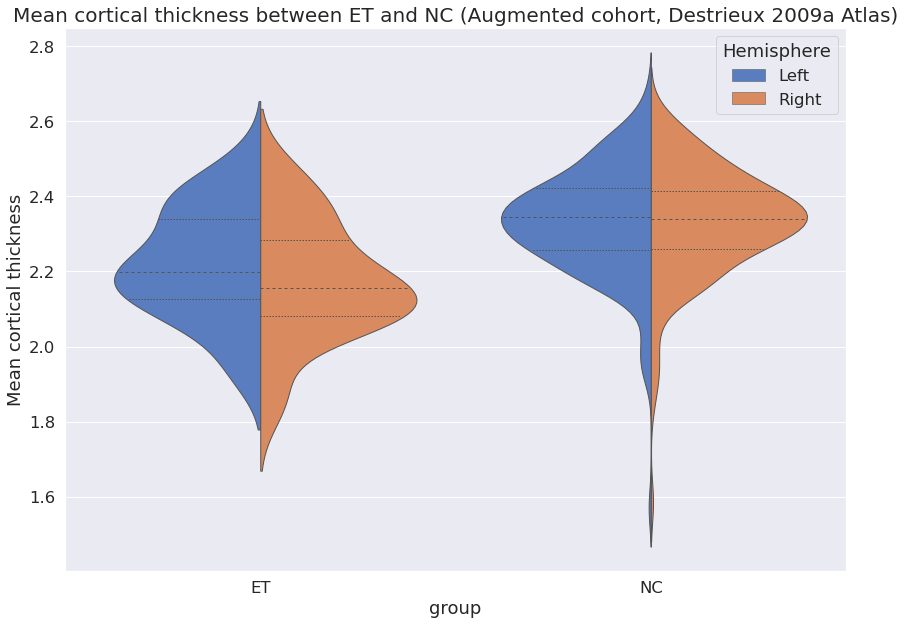

In [5]:
#Mean cortical thickness for left and right hemisphere
lr_mct_vis=data_df.copy()

l_mct=lr_mct_vis[['group','cohort','lh_MeanThickness_thickness']].copy(); 
l_mct.loc[:,'Hemisphere']='Left'; 
l_mct.loc[:,'Mean cortical thickness']=l_mct.loc[:,'lh_MeanThickness_thickness'];
#l_mct=l_mct.drop(columns=['left_mean_cortical_thickness'])

r_mct=lr_mct_vis[['group','cohort','rh_MeanThickness_thickness']].copy(); 
r_mct.loc[:,'Hemisphere']='Right'; 
r_mct.loc[:,'Mean cortical thickness']=r_mct.loc[:,'rh_MeanThickness_thickness'];
#r_mct=r_mct.drop(columns=['rh_MeanThickness_thickness'])

vis_df=pd.concat([r_mct, l_mct])
vis_df=vis_df.sort_values(by=['Hemisphere'], ascending=1)

vis_mni_df=vis_df.copy()
vis_mni_df=vis_mni_df[vis_mni_df['cohort']=='MNI'];
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.5)

# Draw a nested violinplot and split the violins for easier comparison
fig, ax = plt.subplots(figsize=(14, 10))
sns.violinplot(data=vis_df, x="group", y="Mean cortical thickness", hue="Hemisphere", order=['ET','NC'],split=True, inner="quartile", linewidth=1, palette="muted", ax=ax)
#sns.despine(left=True)
ax.set_title('Mean cortical thickness between ET and NC (Augmented cohort, Destrieux 2009a Atlas)', fontsize=20)
#fig.savefig("AugCohort_SUIT-MAGeT_comp.jpg")

In [38]:
vis_df

,age,sex,site,group,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,...,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,L_I_IV,R_I_IV
sub_0016,78,M,mni_001,ET,25529.9,863.2,16078.0,56382.2,6522.6,3278.0,...,11598.0,10600.00,5421.00,4448.00,3894.00,4662.00,599.000,7896.00,3754.0000,3342.0000
sub_002S0295,89,M,adni_002,NC,28793.9,1161.8,12780.0,54611.8,7128.1,3358.3,...,13836.9,7751.39,4060.57,3996.50,3872.36,3654.78,594.002,7739.38,3094.1485,2695.0320
sub_002S4225,70,M,adni_002,NC,23852.7,796.2,16486.6,54874.6,7387.1,3784.2,...,15220.8,8698.78,4496.39,4634.39,3979.19,3854.39,860.398,9451.18,3587.9879,2945.9997
sub_003S0907,95,F,adni_003,NC,23099.0,1289.6,10576.0,49044.6,5124.2,2574.0,...,14130.1,8285.66,4395.02,3448.14,3131.26,3376.89,691.878,7391.28,3328.1383,2735.6383
sub_003S4288,75,F,adni_003,NC,14402.4,502.4,12139.7,43333.1,5399.7,2736.7,...,10162.3,7261.68,3803.04,3470.65,2896.66,2843.27,594.016,6615.60,2815.2325,2195.8610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_941S4066,78,F,adni_941,NC,33709.6,587.0,13042.8,47692.0,5916.6,3055.7,...,12001.5,8207.90,4523.76,3766.91,3222.29,3315.73,746.173,7672.63,3054.1008,2544.1980
sub_941S4255,72,M,adni_941,NC,21023.0,559.4,12675.0,46655.6,5768.8,3073.1,...,12951.6,8415.58,4239.59,4082.39,2859.59,3187.19,697.198,7385.98,2830.7878,2650.7977
sub_941S4292,75,M,adni_941,NC,15109.1,611.8,12620.1,45592.6,6263.2,2790.2,...,10708.8,7842.03,4560.02,4322.42,3064.81,2808.01,614.402,7376.43,3163.2132,2714.4132
sub_941S4365,84,M,adni_941,NC,35674.5,1961.3,13065.3,53090.4,6619.5,3232.0,...,11997.6,9784.78,4711.19,4708.79,4096.79,3013.19,763.198,8531.98,3281.9868,2612.3978


In [5]:
# Heatmap of correlation between cerebellum ROIs and cortical thickness measures, MNI cohort
C_MAP='coolwarm'; TH=0.3
vis_df=data_df.copy()
vis_df=vis_df.loc[:,cerebellum_list+SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+Des_atlas_rh_list+Des_atlas_lh_list]

corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')
#mask_=mask_.where(mask_==np.NaN, True)

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=False, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("Cerebellum volumes (upper), Cortical Thickness(lower)")
ax.set_xlabel("Cerebellum volumes (left), Cortical Thickness(right)")
ax.set_title('Correlation between Cerebellum volumns and cortical thickness (MNI cohort ET+NC)', fontsize=28)
#line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
#for x in line_pos:
#    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
#f1.savefig("MNI_SUIT-MAGeT_comp.jpg")
display(corr_)

NameError: name 'cerebellum_list' is not defined